In [29]:
import pandas as pd
import numpy as np
import glob
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error, precision_score, recall_score, accuracy_score, f1_score, r2_score
from sklearn.model_selection import validation_curve, learning_curve, cross_val_score, StratifiedKFold
import dask
import dask.dataframe as dd
from dask.distributed import Client
from dask_ml.model_selection import HyperbandSearchCV
from dask_ml.model_selection import GridSearchCV 
from dask_ml.model_selection import KFold
from dask_ml.linear_model import LogisticRegression
import dask.array as da

In [30]:
import imblearn
from imblearn.over_sampling import SMOTE 

In [31]:
start_time = time.time() 

In [32]:
client = Client()

C:\Users\stack\AppData\Roaming\Python\Python312\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55076 instead
  warnings.warn(


In [33]:
asteroid_df = dd.read_csv("data/asteroid_normalized_small_df.csv")
asteroid_df = asteroid_df.drop(columns = ['diameter', 'albedo', 'a', 'i', 'neo']) #, inplace = True)
# Repartition the DataFrame to a specific number of partitions
desired_partitions = 8
asteroid_df = asteroid_df.repartition(npartitions=desired_partitions)

asteroid_df

,pha,H,e,q,n,moid,spkid,full_name
npartitions=8,,,,,,,,
,int64,float64,float64,float64,float64,float64,int64,string
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


## Split data

In [34]:
exclude_col = ['pha', 'spkid', 'full_name']
X = asteroid_df.drop(columns = exclude_col)
y = asteroid_df.iloc[:, 0]

In [35]:
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

C:\Users\stack\AppData\Roaming\Python\Python312\site-packages\dask_ml\model_selection\_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [36]:
# Check the number of partitions in X_train and y_train
num_partitions_X = X_train.npartitions
num_partitions_y = y_train.npartitions

print(f'Number of partitions in X_train: {num_partitions_X}')
print(f'Number of partitions in y_train: {num_partitions_y}')

Number of partitions in X_train: 8
Number of partitions in y_train: 8


## Grid Search

In [37]:
#from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

tuned_parameters = [{'loss': ['hinge', 'log_loss', 'modified_huber'], 
                     'penalty': ['l2', 'elasticnet'],
                     'l1_ratio': [0, 0.2, 0.5, 1],
                     'max_iter': [100, 300]}]

score = 'accuracy'

print("# Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(SGDClassifier(), tuned_parameters, cv=5,
                   scoring=score)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
results = clf.cv_results_
for i in range(len(results["params"])):
    print("%0.3f (+/-%0.03f) for %r" % (results["mean_test_score"][i], results["std_test_score"][i] * 2, results["params"][i]))

# Tuning hyper-parameters for accuracy



2024-10-30 15:52:13,623 - distributed.scheduler - WARNING - Detected different `run_spec` for key '_indexable-1d1797833e1572da223d6d30f2116864' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function _indexable at 0x00000286B539E020>, ('finalize-01aef68d-551b-44d3-a347-18ec5173a043',), {})
new run_spec: (<function _indexable at 0x00000286B539E020>, ('finalize-1454d923-7dfb-487c-8432-b2a68fd3d575',), {})
old token: ('tuple', (('78cad60bb445e950', []), ('tuple', ('finalize-01aef68d-551b-44d3-a347-18ec5173a043',)), ('dict', ())))
new token: ('tuple', (('78cad60bb445e950', []), ('tuple', ('finalize-1454d923-7dfb-487c-8432-b2

Best parameters set found on development set:

{'l1_ratio': 0, 'loss': 'modified_huber', 'max_iter': 300, 'penalty': 'elasticnet'}

Grid scores on development set:

0.994 (+/-0.016) for {'l1_ratio': 0, 'loss': 'hinge', 'max_iter': 100, 'penalty': 'l2'}
0.994 (+/-0.016) for {'l1_ratio': 0, 'loss': 'hinge', 'max_iter': 100, 'penalty': 'elasticnet'}
0.994 (+/-0.015) for {'l1_ratio': 0, 'loss': 'hinge', 'max_iter': 300, 'penalty': 'l2'}
0.994 (+/-0.015) for {'l1_ratio': 0, 'loss': 'hinge', 'max_iter': 300, 'penalty': 'elasticnet'}
0.994 (+/-0.015) for {'l1_ratio': 0, 'loss': 'log_loss', 'max_iter': 100, 'penalty': 'l2'}
0.994 (+/-0.016) for {'l1_ratio': 0, 'loss': 'log_loss', 'max_iter': 100, 'penalty': 'elasticnet'}
0.994 (+/-0.016) for {'l1_ratio': 0, 'loss': 'log_loss', 'max_iter': 300, 'penalty': 'l2'}
0.994 (+/-0.015) for {'l1_ratio': 0, 'loss': 'log_loss', 'max_iter': 300, 'penalty': 'elasticnet'}
0.994 (+/-0.015) for {'l1_ratio': 0, 'loss': 'modified_huber', 'max_iter': 100, 'penalt

In [38]:
print("Best Parameters:", clf.best_params_)
print("Best Cross-Validation Score:", clf.best_score_)

Best Parameters: {'l1_ratio': 0, 'loss': 'modified_huber', 'max_iter': 300, 'penalty': 'elasticnet'}
Best Cross-Validation Score: 0.9947396107311941


In [39]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27585
           1       0.35      0.26      0.29        74

    accuracy                           1.00     27659
   macro avg       0.67      0.63      0.65     27659
weighted avg       1.00      1.00      1.00     27659



In [40]:
clf_best = SGDClassifier(l1_ratio = 0.5, loss = 'modified_huber', max_iter= 300, penalty = 'l2')

## Hyperband Search

In [41]:
tuned_parameters = [{'loss': ['hinge', 'log_loss', 'modified_huber'], 
                     'penalty': ['l2', 'elasticnet'],
                     'l1_ratio': [0, 0.2, 0.5, 1],
                     'max_iter': [100, 300]}]

# Initialize logistic regression model
clf = SGDClassifier()

# Create HyperbandSearchCV object
hyperband_search = HyperbandSearchCV(estimator = clf, parameters = tuned_parameters, scoring='accuracy')

y_array = y.to_dask_array()
classes = da.unique(y_array).compute()
hyperband_search.fit(X_train, y_train, classes=classes)

C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 48 is smaller than n_iter=81. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


HyperbandSearchCV(estimator=SGDClassifier(),
                  parameters=[{'l1_ratio': [0, 0.2, 0.5, 1],
                               'loss': ['hinge', 'log_loss', 'modified_huber'],
                               'max_iter': [100, 300],
                               'penalty': ['l2', 'elasticnet']}],
                  scoring='accuracy')

In [42]:
hyperband_search.cv_results_

{'mean_partial_fit_time': array([0.00388014, 0.00517607, 0.00485176, 0.00594342, 0.00599098,
        0.00633589, 0.00773478, 0.00641735, 0.00778063, 0.00671983,
        0.00443077, 0.00620532, 0.00912929, 0.00532738, 0.00445414,
        0.00540864, 0.00859272, 0.00925839, 0.0085485 , 0.00464952,
        0.00587595, 0.00545681, 0.00626314, 0.00438046, 0.00666368,
        0.0087477 , 0.00603271, 0.00724816, 0.00983   , 0.01045179,
        0.00628948, 0.00780725, 0.00730228, 0.00769901, 0.00773764,
        0.00585032, 0.00574183, 0.0082233 , 0.00579047, 0.00418973,
        0.00614381, 0.0063715 , 0.00888777, 0.00510478, 0.00716782,
        0.00727177, 0.00716925, 0.00473142, 0.00646877, 0.00848039,
        0.00696075, 0.00770116, 0.00940835, 0.0067147 , 0.00530043,
        0.00726112, 0.00586075, 0.01091258, 0.00377202, 0.00861112,
        0.01058507, 0.00419307, 0.00515556, 0.01002228, 0.0060389 ,
        0.01091361, 0.00493896, 0.00722778, 0.00536585, 0.00727177,
        0.00358558, 0.0

In [43]:
print("Best Parameters:", hyperband_search.best_params_)
print("Best Cross-Validation Score:", hyperband_search.best_score_)


Best Parameters: {'penalty': 'elasticnet', 'max_iter': 100, 'loss': 'log_loss', 'l1_ratio': 1}
Best Cross-Validation Score: 0.9983875696276752


In [44]:
clf_best = SGDClassifier(penalty= 'elasticnet', max_iter= 100, loss= 'modified_huber', l1_ratio= 1)
clf_best.fit(X_train, y_train)

SGDClassifier(l1_ratio=1, loss='modified_huber', max_iter=100,
              penalty='elasticnet')

In [45]:
y_true, y_pred = y_test, clf_best.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27585
           1       0.66      0.65      0.65        74

    accuracy                           1.00     27659
   macro avg       0.83      0.82      0.83     27659
weighted avg       1.00      1.00      1.00     27659



### Model validation via cross-validation

In [46]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf_best, X.compute(), y.compute(), cv=5)

array([0.99923869, 0.99970998, 0.9995287 , 0.9991299 , 0.95993909])

In [47]:
from imblearn.pipeline import Pipeline  # Use imblearn's Pipeline
from imblearn.over_sampling import SMOTE

pipeline = Pipeline([
    ('smote', SMOTE()),                 
    ('SGDClassifier', clf_best)     
])

scores = cross_val_score(pipeline, X.compute(), y.compute(), cv=5)
print("Cross-validation scores with SMOTE:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores with SMOTE: [0.99996375 1.         0.99996375 0.99996375 0.96070043]
Mean accuracy: 0.9921183340191634


In [48]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X.compute(), y.compute(), cv=skf)

res = [clf_best.fit(X.compute().iloc[train], y.compute().iloc[train]).score(X.compute().iloc[test], y.compute().iloc[test]) for train, test in skf.split(X.compute(), y.compute())]
#res is a score vector within 0,1
np.mean(res) #The average accuracy
print("Cross-validation scores with SMOTE:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores with SMOTE: [0.99847738 0.9987674  0.99833231 0.99891237 0.99862234]
Mean accuracy: 0.9986223598246775


## Cross Validation without KFold

In [49]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)  
scores = cross_val_score(pipeline, X.compute(), y.compute(), cv=kf)

print("Cross-validation scores with SMOTE:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores with SMOTE: [0.99851363 0.99862239 0.99909364 0.99796976 0.99869485]
Mean accuracy: 0.998578855555807


## Validation Curve (for a Single Hyperparameter)

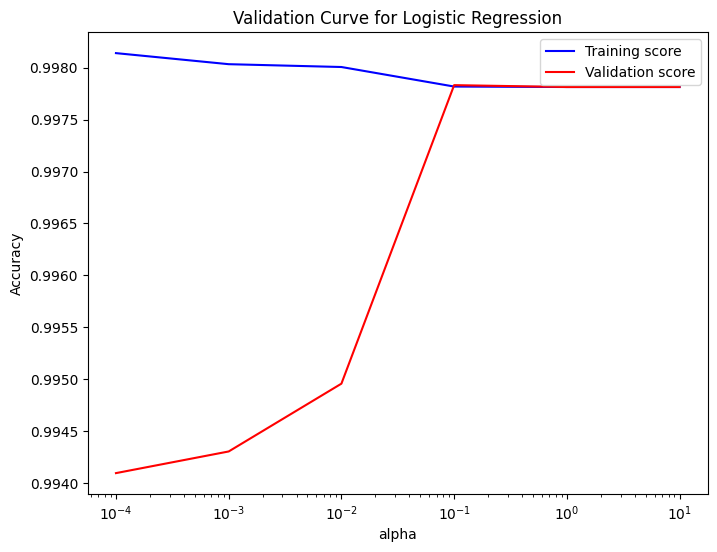

In [50]:
from sklearn.model_selection import validation_curve

X_train = X_train.compute()
y_train = y_train.compute()

param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10]

train_scores, val_scores = validation_curve(
    SGDClassifier(max_iter=1000, tol=1e-3, random_state=42),
    X_train, y_train,
    param_name="alpha",
    param_range=param_range,
    cv=5,
    scoring="accuracy"
)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label="Training score", color="blue")
plt.plot(param_range, np.mean(val_scores, axis=1), label="Validation score", color="red")
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.title("Validation Curve for Logistic Regression")
plt.xscale("log")  # Log scale for C
plt.legend()
plt.show()

In [51]:
client.close()

In [52]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")
#Execution time: 40.30 seconds

Execution time: 40.93 seconds
